## Setup

In [1]:
import torch
torch.cuda.set_device(6)

from slice_e2e_shallow import *
pd.options.display.max_rows = 999

In [2]:
val_sids = sids[s_splits[1]]
df_sids = pd.DataFrame(val_sids).set_index(0)
df_slices = df_sids.merge(df, left_index=True, right_index=True).reset_index()
y = to_device(tensor(df_slices[htypes].values))

In [3]:
pres = '''train_rn18_all-e2e rn18_wgtd_freeze2-e2e train_rn18-e2e
    rn18_wgtd-e2e-fr train_rn34-e2e-fr xrn34_wgtd_deep-e2e-fr'''.split()

In [4]:
all_preds = [(path_pred/f'{pre}.pkl').load() for pre in pres]
flp_preds = [(path_pred/f'{pre}-flip.pkl').load() for pre in pres]

In [5]:
[lf2(to_device((o+p)/2),y) for o,p in zip(all_preds,flp_preds)]

[tensor(0.0634, device='cuda:6'),
 tensor(0.0629, device='cuda:6'),
 tensor(0.0631, device='cuda:6'),
 tensor(0.0624, device='cuda:6'),
 tensor(0.0639, device='cuda:6'),
 tensor(0.0629, device='cuda:6')]

In [6]:
[(lf2(to_device(o),y), accuracy_multi(to_device(o),y)) for o in all_preds]

[(tensor(0.0646, device='cuda:6'), tensor(0.9784, device='cuda:6')),
 (tensor(0.0641, device='cuda:6'), tensor(0.9785, device='cuda:6')),
 (tensor(0.0638, device='cuda:6'), tensor(0.9784, device='cuda:6')),
 (tensor(0.0635, device='cuda:6'), tensor(0.9788, device='cuda:6')),
 (tensor(0.0645, device='cuda:6'), tensor(0.9782, device='cuda:6')),
 (tensor(0.0634, device='cuda:6'), tensor(0.9791, device='cuda:6'))]

In [7]:
lf = nn.BCELoss(weight=loss_weights)

In [8]:
avg_preds = torch.stack(all_preds+flp_preds).mean(0)
lf2(to_device(avg_preds),y), accuracy_multi(to_device(avg_preds),y)

(tensor(0.0591, device='cuda:6'), tensor(0.9798, device='cuda:6'))

In [9]:
flp_avg = list((torch.stack(all_preds)+torch.stack(flp_preds))/2)

In [10]:
cat_preds = torch.cat(flp_avg, dim=1)
df_preds = pd.DataFrame(cat_preds.numpy())
pred_cols = [f'{pre}:{c}' for pre in pres for c in htypes]
df_preds.columns = pred_cols
df_preds[['Left','Right']] = df_slices[['Left','Right']]

In [11]:
df_preds.index = df_slices['SOPInstanceUID']

In [12]:
# df_l = pd.merge(df_preds, df_preds, how='left', right_index=True, left_on="Left",
#                 suffixes=["","_l"]).drop(['Left_l','Right_l'], axis=1)
# df_r = pd.merge(df_l, df_preds, how='left', right_index=True, left_on="Right",
#                 suffixes=["","_r"]).drop(['Left_r','Right_r'], axis=1)
# df_r.drop(['Left','Right'], axis=1, inplace=True)

# df_r[pd.isna(df_r)] = 0
# df_preds = df_r.reset_index(drop=False)

In [13]:
df_preds.reset_index(drop=False, inplace=True)

In [14]:
df_preds[htypes] = df_slices[htypes].astype(np.float32)
df_preds['SeriesInstanceUID'] = df_slices['index']

In [15]:
set_seed(42)
mask = np.random.random(len(val_sids))>0.1
ens_trn_sids,ens_val_sids = val_sids[mask],val_sids[~mask]

In [16]:
df_preds.set_index('SeriesInstanceUID', inplace=True)
df_val = df_preds.loc[ens_val_sids].reset_index()
df_trn = df_preds.loc[ens_trn_sids].reset_index()
len(df_trn),len(df_val)

(122286, 14499)

In [17]:
yev = df_val[htypes].values
yet = df_trn[htypes].values
yev_t = to_device(tensor(yev))
xev = df_val[pred_cols].values
xet = df_trn[pred_cols].values

## Baseline average

In [18]:
xev_s = np.array_split(xev, 6, 1)
xev_m = np.stack(xev_s).mean(0)
xev_mt = to_device(tensor(xev_m))

In [19]:
lf2(xev_mt,yev_t), accuracy_multi(xev_mt,yev_t)

(tensor(0.0698, device='cuda:6'), tensor(0.9761, device='cuda:6'))

In [20]:
opt_val_loss(xev_mt,yev_t, full=True)

     fun: tensor(0.0697)
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: tensor(0.9519)

## Linear

In [18]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

In [19]:
cw = to_np(loss_weights)

In [20]:
regr = LogisticRegression(solver='lbfgs')
mreg = MultiOutputClassifier(regr, n_jobs=32)
reg = mreg.fit(xet, yet)

In [21]:
vp = [o[:,1] for o in reg.predict_proba(xev)]
vps = np.stack(vp, axis=1)
lf = nn.BCEWithLogitsLoss(weight=loss_weights)
p = to_device(logit(tensor(vps)))
lf2(p, yev_t.float()),accuracy_multi(p, yev_t.float())

(tensor(0.0686, device='cuda:6'), tensor(0.9770, device='cuda:6'))

In [23]:
optv = opt_val_loss(p,yev_t.float(), full=True)
optx = optv.x
optv

     fun: tensor(0.0683)
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: tensor(0.9281)

## Tabular

In [30]:
from fastai2.tabular.core import *
from fastai2.tabular.model import *

In [31]:
df_tab = pd.concat([df_trn, df_val])

In [32]:
splits = [list(range(len(df_trn))), list(range(len(df_trn), len(df_tab)))]
# procs = []
procs = [Normalize]

In [33]:
to = TabularPandas(df_tab, procs, None, pred_cols, y_names=htypes,
                   block_y=MultiCategoryBlock(encoded=True, vocab=htypes), splits=splits)

In [34]:
dbch = to.dataloaders(bs=256, after_batch=Cuda)

In [106]:
dbch.valid.show_batch()

,train_rn18_all-e2e:any,train_rn18_all-e2e:epidural,train_rn18_all-e2e:intraparenchymal,train_rn18_all-e2e:intraventricular,train_rn18_all-e2e:subarachnoid,train_rn18_all-e2e:subdural,rn18_wgtd_freeze2-e2e:any,rn18_wgtd_freeze2-e2e:epidural,rn18_wgtd_freeze2-e2e:intraparenchymal,rn18_wgtd_freeze2-e2e:intraventricular,rn18_wgtd_freeze2-e2e:subarachnoid,rn18_wgtd_freeze2-e2e:subdural,train_rn18-e2e:any,train_rn18-e2e:epidural,train_rn18-e2e:intraparenchymal,train_rn18-e2e:intraventricular,train_rn18-e2e:subarachnoid,train_rn18-e2e:subdural,rn18_wgtd-e2e-fr:any,rn18_wgtd-e2e-fr:epidural,rn18_wgtd-e2e-fr:intraparenchymal,rn18_wgtd-e2e-fr:intraventricular,rn18_wgtd-e2e-fr:subarachnoid,rn18_wgtd-e2e-fr:subdural,train_rn34-e2e-fr:any,train_rn34-e2e-fr:epidural,train_rn34-e2e-fr:intraparenchymal,train_rn34-e2e-fr:intraventricular,train_rn34-e2e-fr:subarachnoid,train_rn34-e2e-fr:subdural,xrn34_wgtd_deep-e2e-fr:any,xrn34_wgtd_deep-e2e-fr:epidural,xrn34_wgtd_deep-e2e-fr:intraparenchymal,xrn34_wgtd_deep-e2e-fr:intraventricular,xrn34_wgtd_deep-e2e-fr:subarachnoid,xrn34_wgtd_deep-e2e-fr:subdural,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,-8.238376,-17.297939,-11.920480,-13.801267,-8.112549,-11.807898,-11.469049,-48.865624,-21.400269,-31.216509,-13.093112,-18.295864,-8.641256,-17.059513,-11.449665,-11.519353,-10.864289,-11.979290,-10.082086,-51.885269,-21.977497,-20.055372,-13.080116,-15.691304,-6.949860,-14.042627,-10.161537,-13.418343,-8.311250,-8.792625,-57.777737,-294.844643,-119.424292,-119.933349,-77.936313,-127.467362,False,False,False,False,False,False
1,-8.894002,-23.112486,-13.503254,-16.370792,-9.410556,-16.119137,-14.027308,-90.660106,-34.550870,-42.426856,-19.474388,-32.251309,-11.616915,-25.087519,-15.819075,-16.251137,-15.958450,-17.463702,-10.837638,-86.797811,-29.641816,-22.678650,-19.088266,-22.328073,-7.536536,-18.096712,-11.853873,-16.381811,-9.462038,-11.018987,-78.903519,-420.682998,-173.893171,-183.870655,-98.145798,-176.540264,False,False,False,False,False,False
2,-8.119171,-21.655539,-12.158889,-14.291330,-7.933742,-14.503250,-12.776923,-85.946008,-29.017556,-35.154503,-18.022791,-29.894262,-10.836414,-23.289580,-14.411385,-16.836514,-15.094324,-15.860887,-10.094175,-88.441892,-26.232767,-18.411291,-17.964004,-21.095013,-7.408670,-18.969206,-11.748572,-17.043703,-9.597425,-10.958816,-77.630879,-452.448059,-187.230416,-211.359621,-105.170753,-190.182931,False,False,False,False,False,False
3,-7.781424,-19.138993,-11.556243,-12.046307,-7.331095,-12.278094,-9.543168,-59.156147,-17.419157,-24.777745,-12.769736,-19.460015,-8.355537,-18.411451,-11.059415,-14.383511,-12.000196,-12.007165,-9.247957,-74.225433,-21.215900,-14.893441,-16.259479,-18.411292,-7.092768,-17.991411,-11.154374,-15.885393,-8.965619,-10.221709,-53.196241,-324.777060,-131.539796,-154.040023,-73.507534,-135.103183,False,False,False,False,False,False
4,-8.297978,-18.595947,-12.225114,-11.814520,-8.615858,-11.880745,-9.658147,-44.582695,-15.320809,-21.730829,-12.848784,-15.004621,-8.487944,-16.585638,-10.174383,-14.355636,-11.512384,-11.212727,-8.365472,-54.641521,-16.416634,-12.076744,-14.095578,-15.268195,-7.134136,-17.164047,-10.913686,-14.907598,-8.785104,-9.860677,-29.372470,-193.949931,-75.391036,-91.426269,-40.571681,-76.969107,False,False,False,False,False,False
5,-8.311223,-18.066149,-12.344319,-12.039684,-9.543006,-11.331078,-9.945591,-35.326969,-14.559081,-19.646854,-12.834412,-13.121857,-8.257975,-15.247637,-9.296320,-14.397449,-10.787633,-10.446164,-7.507165,-32.809090,-11.085460,-9.423244,-10.082087,-10.801372,-7.235676,-16.186253,-10.567697,-14.020062,-8.732453,-9.484603,-19.840418,-122.784058,-46.553077,-60.170295,-25.210947,-46.451263,False,False,False,False,False,False
6,-8.291356,-16.980060,-12.105909,-12.642331,-10.125785,-10.430420,-8.580228,-23.196798,-10.491736,-15.407043,-10.484550,-9.543168,-8.453100,-14.467136,-8.982725,-14.355636,-10.404351,-10.035007,-8.347339,-20.937858,-9.755688,-10.311774,-9.900754,-

In [36]:
model = TabularModel(get_emb_sz(to), len(to.cont_names), 6, layers=[1000,500], ps=[0.001,0.01])
# model = TabularModel(get_emb_sz(to), len(to.cont_names), 6, layers=[200,100], ps=[0.,0.])
opt_func = partial(Adam, wd=0.001, eps=1e-5)
learn = Learner(dbch, model, loss_func, opt_func=opt_func, metrics=metrics)

avg_lbls = df[htypes].mean()
learn.model.layers[-1][0].bias.data = to_device(tensor(scipy.special.logit(avg_lbls.values)))

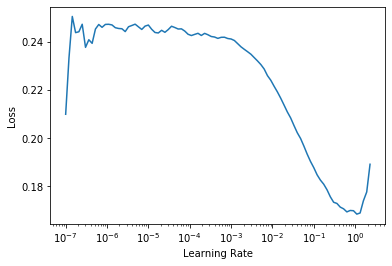

In [134]:
learn.lr_find(end_lr=10)

In [23]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,None,accum,time
0,0.060577,0.077482,0.973389,0.960618,0.077482,0.076293,00:11
1,0.062870,0.071571,0.975952,0.959170,0.071571,0.071305,00:11
2,0.060341,0.073200,0.975630,0.958894,0.073200,0.073180,00:11
3,0.055940,0.069958,0.976205,0.960204,0.069958,0.069388,00:11
4,0.058380,0.068828,0.976711,0.961101,0.068828,0.068504,00:11


In [37]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,None,accum,time
0,0.063583,0.077152,0.973803,0.960135,0.077152,0.075655,00:12
1,0.062399,0.070169,0.976228,0.961170,0.070169,0.069754,00:11
2,0.060438,0.070341,0.976768,0.961653,0.070341,0.070136,00:11
3,0.058490,0.068444,0.976837,0.961446,0.068444,0.068299,00:11
4,0.055634,0.069772,0.976619,0.960687,0.069772,0.069392,00:11


In [38]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,None,accum,time
0,0.057431,0.069954,0.976389,0.959859,0.069954,0.069656,00:12
1,0.057479,0.070082,0.976159,0.959239,0.070082,0.069847,00:12
2,0.058718,0.069226,0.976803,0.961721,0.069226,0.068843,00:11
3,0.057396,0.069076,0.976573,0.961515,0.069076,0.068915,00:11
4,0.057621,0.069314,0.976757,0.961032,0.069314,0.068893,00:11


## GBM

In [18]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [19]:
clf = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=100,
    max_leaf_nodes=31,
    min_samples_leaf=2000,
    max_depth=4,
    l2_regularization=1.0,
    loss='binary_crossentropy',
    verbose=1,
)
mreg = MultiOutputClassifier(clf, n_jobs=16)
reg = mreg.fit(xet, yet)
reg.score(xev, yev)

0.9146148010207601

In [20]:
vp = [o[:,1] for o in reg.predict_proba(xev)]
vps = np.stack(vp, axis=1)
p = to_device(logit(tensor(vps)))
lf2(p, yev_t.float()),accuracy_multi(p, yev_t.float())

(tensor(0.0680, device='cuda:6'), tensor(0.9767, device='cuda:6'))

In [21]:
opt_val_loss(p,yev_t.float(), full=True)

     fun: tensor(0.0680)
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: tensor(0.9880)

## Submit GBM

In [24]:
from slice_e2e_test import *
pd.options.display.max_rows = 999

In [25]:
# df_sids = pd.DataFrame(sids).set_index(0)
# df_slices = df_sids.merge(df, left_index=True, right_index=True).reset_index().set_index('SOPInstanceUID')

In [26]:
dl = dls.valid
osids = L(dl).itemgot(0).map(list)
ssids = L(sum(osids,[]))
df2 = pd.DataFrame(ssids).set_index(0)

In [27]:
pres = '''train_rn18_all-e2e rn18_wgtd_freeze2-e2e train_rn18-e2e
    rn18_wgtd-e2e-fr train_rn34-e2e-fr xrn34_wgtd_deep-e2e-fr'''.split()

all_preds = [(path_pred_test/f'{pre}.pkl'     ).load() for pre in pres]
flp_preds = [(path_pred_test/f'{pre}-flip.pkl').load() for pre in pres]
flp_avg = list((torch.stack(all_preds)+torch.stack(flp_preds))/2)
cat_preds = torch.cat(flp_avg, dim=1)

In [28]:
xev = to_np(cat_preds)

In [29]:
vp = [o[:,1] for o in reg.predict_proba(xev)]
vps = np.stack(vp, axis=1)

In [30]:
a=1e-5
avg_pred = tensor(vps).clamp(a,1-a)

In [48]:
p = (logit(tensor(vps))*optx).sigmoid()
a=1e-7
avg_pred = p.clamp(a,1-a)

In [49]:
dfc = submission(df2, avg_pred, fn='lin-noclamp-opt')

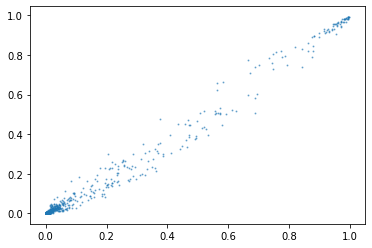

In [50]:
prev = pd.read_csv('clamp-final.csv')
dfc.Label = dfc.Label.astype(np.float)
plt.scatter(dfc.Label[:4000], prev.Label[:4000], alpha=0.5, s=1);

## RF

In [122]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
clf = RandomForestClassifier(
    oob_score=True,
    n_jobs=32,
    n_estimators=30,
    min_samples_leaf=20,
    max_features=0.9,
    min_samples_split=5,
)
mreg = MultiOutputClassifier(clf, n_jobs=1)
reg = mreg.fit(xet, yet)

In [135]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=10, max_features=0.8, n_jobs=32, oob_score=True)

In [136]:
reg = clf.fit(xet, yet)

In [138]:
reg.oob_score_

0.9828121507504267

In [133]:
vp = [o[:,1] for o in reg.predict_proba(xev)]
vps = np.stack(vp, axis=1)
p = to_device(logit(tensor(vps)))
lf2(p, yev_t.float()),accuracy_multi(p, yev_t.float())

(tensor(0.0751, device='cuda:6'), tensor(0.9763, device='cuda:6'))

In [139]:
vp = [o[:,1] for o in reg.predict_proba(xev)]
vps = np.stack(vp, axis=1)
p = to_device(logit(tensor(vps)))
lf2(p, yev_t.float()),accuracy_multi(p, yev_t.float())

(tensor(0.0715, device='cuda:6'), tensor(0.9762, device='cuda:6'))

In [140]:
opt_val_loss(p,yev_t.float(), full=True)

     fun: tensor(0.0712)
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: tensor(0.9223)